# **Machine Learning for Fraud Detection.**

##### **Notebook Author**: A.D. Téllez

You can find me on GitHub for collaborations.

# Model Development

In [26]:
import pandas as pd

##### This data sets is under public domain.

In [27]:
card_df = pd.read_csv('card_transdata.csv')

#quick look to our data.
card_df.head() 

distance_from_home  distance_from_last_transaction  \
0           57.877857                        0.311140   
1           10.829943                        0.175592   
2            5.091079                        0.805153   
3            2.247564                        5.600044   
4           44.190936                        0.566486   

   ratio_to_median_purchase_price  repeat_retailer  used_chip  \
0                        1.945940              1.0        1.0   
1                        1.294219              1.0        0.0   
2                        0.427715              1.0        0.0   
3                        0.362663              1.0        1.0   
4                        2.222767              1.0        1.0   

   used_pin_number  online_order  fraud  
0              0.0           0.0    0.0  
1              0.0           0.0    0.0  
2              0.0           1.0    0.0  
3              0.0           1.0    0.0  
4              0.0           1.0    0.0

### Preparing the data for the model

#### 1. Total observations in our database.

In [28]:
print(card_df.shape[0],"observations.")

1000000 observations.


#### 2. Looking for null values.

Sometimes we have null values in our data sets. Since they can compromise the performance of our model, we need to identify and treat them properly. Just deleting is not always the best solution.

In [29]:
card_df.isnull().sum()

distance_from_home                0
distance_from_last_transaction    0
ratio_to_median_purchase_price    0
repeat_retailer                   0
used_chip                         0
used_pin_number                   0
online_order                      0
fraud                             0
dtype: int64

#### 3. Fraud incidences distribution on data set

In [30]:
fraud_df = card_df.value_counts(card_df['fraud']).rename(index = 'Number of cases').to_frame() #counts how many incidences belongs to each cases.  
fraud_df

Number of cases
fraud                 
0.0             912597
1.0              87403

array([<Axes: >], dtype=object)

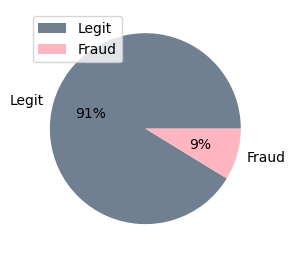

In [31]:
#Visual distribution 
colors = ['slategrey','lightpink']
fraud_df.plot(kind='pie',subplots = 'True', autopct='%1.0f%%',colors=colors,labels = {'Legit':0,'Fraud':1},ylabel='',figsize=(3.1,3.1))

####  Aiming for an equal outcome distribution 

There's an unfair distribution between normal and fraudulent transactions. This can bias our model.

##### Separate the two classes 

In [32]:
# separating the normal transactions
legit = card_df[card_df.fraud == 0]

#look some statistical info about normal transactions
legit.distance_from_home.describe()

count    912597.000000
mean         22.832976
std          52.828655
min           0.004874
25%           3.828942
50%           9.673847
75%          24.158057
max        8777.136420
Name: distance_from_home, dtype: float64

In [33]:
# separating the normal transactions
fraud = card_df[card_df.fraud == 1]

#look some statistical info about fraudulent transactions
fraud.distance_from_home.describe()

count    87403.000000
mean        66.261876
std        134.391608
min          0.025847
25%          4.585729
50%         15.454219
75%        101.110104
max      10632.723672
Name: distance_from_home, dtype: float64

**After that, we see fraudulent transactions has a correlation with the distance.** 

We can extend this exploratory analysis for other attributes on the dataframe. We selected just one in order to eliminate distracting values.   

##### Pick an equal distribution of each class

In [34]:
legit_sample = legit.sample(n = 87403) #n is the number of random observations to make a sample set. Also n = number of fraudulent transactions

We join the now 2 balanced datasets:

**legit_sample** ---> the reduced dataset of legit transactions

**fraud** ---> dataset with fraudulent transactions

In [35]:
sample = pd.concat( [legit_sample, fraud] , axis = 0) # axis = 0 concatenate rows 

In [36]:
sample_table = sample.value_counts(sample['fraud'].rename(index = 'Number of cases'))

Number of cases
0.0    87403
1.0    87403
dtype: int64

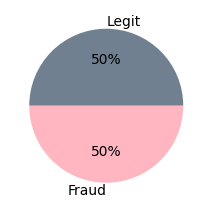

In [37]:
colors = ['slategrey','lightpink']
sample_table.plot(kind='pie',subplots = 'True', autopct='%1.0f%%',colors=colors,labels = {'Legit':0,'Fraud':1},ylabel='',figsize=(2.5,2.5))
sample_table

#### 4. Standardization

This process prepares our data in such a way that the mean is zero. This sets our values within the range [-1,1] preventing extreme values from weighting more in our model.  

In [38]:
# allows us to standardize our data.
from sklearn import preprocessing 

#### Understanding the process

When setting our model, we need some input data called independent variables. But we also need to define what would be the expected outcome. The variable we would like to predict, categorize or cluster is called the dependent variable.  

In [39]:
ind_var = sample.drop(columns='fraud',axis=1)

In [40]:
transform = preprocessing.StandardScaler()  # performs the standardization.

X = transform.fit_transform(ind_var) #Independent variables on the x-axis.
X

array([[-0.35806347, -0.22892445, -0.7320549 , ...,  1.50071455,
        -0.2440729 , -1.90406835],
       [-0.12775284, -0.0326541 , -0.28665717, ...,  1.50071455,
        -0.2440729 , -1.90406835],
       [ 0.27829598, -0.2038952 , -0.53522216, ..., -0.66634924,
        -0.2440729 , -1.90406835],
       ...,
       [ 0.75159883, -0.2325372 , -0.69043006, ..., -0.66634924,
        -0.2440729 ,  0.52519123],
       [ 0.06365236, -0.13899248,  5.51639782, ..., -0.66634924,
        -0.2440729 ,  0.52519123],
       [-0.27162601, -0.18142117,  1.53600776, ...,  1.50071455,
        -0.2440729 ,  0.52519123]])

In [41]:
Y = sample['fraud'].to_numpy()
Y

array([0., 0., 0., ..., 1., 1., 1.])

#### 5. Splitting into train data and test data 

In [42]:
# Allows us to split our data into training and testing data
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [43]:
X_train, X_test, Y_train, Y_test = train_test_split (X, Y, test_size = 0.2, stratify = Y, random_state = 2)

## Logistic Regression Model

In [44]:
model = LogisticRegression()

### Model training

In [45]:
model.fit(X_train,Y_train)

LogisticRegression()

In [46]:
model.get_params(deep=True)

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

### Model evaluation

We use this method in order to predict the value for Y_train which is known, using X_train as input for our model. Then we compare it to see how accurately it performed. 

#### - Training Accuracy

In [47]:
X_train_prediction = model.predict(X_train)
training_accuracy = accuracy_score(X_train_prediction, Y_train)

In [48]:
print("Training Accuracy: ",training_accuracy)

Training Accuracy:  0.9403120620119562


#### - Test Accuracy

In [49]:
X_test_prediction = model.predict(X_test)
testing_accuracy = accuracy_score(X_test_prediction, Y_test)

In [50]:
print("Test Accuracy: ",testing_accuracy)

Test Accuracy:  0.9408214633030147


Our **accuracy is similar** for both train and test data.

- Train accuracy >> Test accuracy implies an Overfitted model.
- Train accuracy << Test accuracy implies an Underfitted model.